## Portfolio Optimisation

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from pandas_datareader import DataReader as web
from datetime import date

In [3]:
assets = ['GOOG', 'AAPL', 'FB', 'TCEHY', 'BILI', 'HSBC']
start = date(2019, 1, 1)
end = date(2020, 12, 21)

df = pd.DataFrame()

for asset in assets:
    df[asset] = web(asset, data_source='yahoo', start=start, end=end)['Adj Close']

df.tail()

,GOOG,AAPL,FB,TCEHY,BILI,HSBC
Date,,,,,,
2020-12-15,1767.770020,127.472664,275.549988,72.924889,76.660004,26.289904
2020-12-16,1763.000000,127.402893,275.670013,73.862381,78.830002,26.016659
2020-12-17,1747.900024,128.290054,274.480011,75.079124,82.190002,26.045937
2020-12-18,1731.010010,126.256561,276.399994,75.109039,84.680000,25.567760
2020-12-21,1739.369995,127.821548,272.790009,73.692833,87.610001,24.962721


<AxesSubplot:xlabel='Date'>

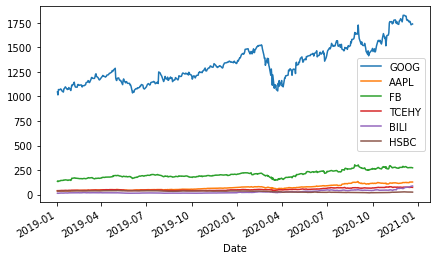

In [4]:
df.plot(figsize=(7, 4))

In [5]:
df_rt = df.copy()

df_rt = np.log(df) - np.log(df.shift(1))
df_rt.tail()

,GOOG,AAPL,FB,TCEHY,BILI,HSBC
Date,,,,,,
2020-12-15,0.004371,0.048876,0.004948,-0.000547,-0.019890,0.009698
2020-12-16,-0.002702,-0.000547,0.000435,0.012774,0.027914,-0.010448
2020-12-17,-0.008602,0.006939,-0.004326,0.016339,0.041740,0.001125
2020-12-18,-0.009710,-0.015978,0.006971,0.000398,0.029846,-0.018530
2020-12-21,0.004818,0.012319,-0.013147,-0.019035,0.034016,-0.023949


<AxesSubplot:xlabel='Date'>

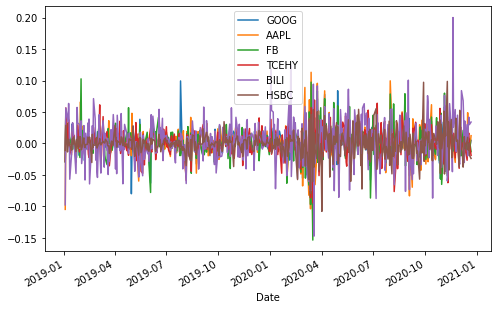

In [6]:
df_rt.plot(figsize=(8, 5))

In [29]:
# Use 252 trading days to annualise the daily return
df_rt.mean() * 252

GOOG     0.257929
AAPL     0.609233
FB       0.354120
TCEHY    0.320167
BILI     0.919793
HSBC    -0.189775
dtype: float64

In [31]:
# Corvariance matrix ajusted to the 252 trading days
df_rt.cov() * 252 

,GOOG,AAPL,FB,TCEHY,BILI,HSBC
GOOG,0.103870,0.086820,0.091183,0.057277,0.061609,0.046293
AAPL,0.086820,0.144508,0.101506,0.073143,0.083683,0.050791
FB,0.091183,0.101506,0.145111,0.060913,0.070069,0.041447
TCEHY,0.057277,0.073143,0.060913,0.116840,0.081193,0.046672
BILI,0.061609,0.083683,0.070069,0.081193,0.300096,0.031885
HSBC,0.046293,0.050791,0.041447,0.046672,0.031885,0.098190


In [38]:
# Generating random weights of selected assets
# Assuming that only long position is allowed

weights = np.random.random(len(assets))
weights /= np.sum(weights)
weights

array([0.21090034, 0.03503907, 0.39884123, 0.09716348, 0.1193644 ,
       0.13869148])

In [43]:
# Portfolio summary
epx_rt = np.sum(df_rt.mean() * weights) * 252
var = np.dot(np.dot(weights.T, df_rt.cov() * 252), weights)
std = np.sqrt(var)

print('The expected return of the constructed porfolio is:', epx_rt)
print('The variance of the constructed portfolio is:', var)
print('The volatility of the constructed portfolio is:', std)

The expected return of the constructed porfolio is: 0.3315607931998794
The variance of the constructed portfolio is: 0.08463268339215009
The volatility of the constructed portfolio is: 0.29091696992810523


## Monte Carlo Simulation

In [11]:
p_returns = []
p_volatility = []

for i in range(2500):
    weights = np.random.random(len(assets))
    weights /= np.sum(weights)

    p_returns.append(np.sum(df_rt.mean() * weights) * 252)
    p_volatility.append(np.sqrt(np.dot(np.dot(weights.T, df_rt.cov() * 252), weights)))

p_returns = np.array(p_returns)
p_volatility = np.array(p_volatility)

In [12]:
p_returns

array([0.38287762, 0.38223532, 0.35278978, ..., 0.31479647, 0.37805295,
       0.35897659])

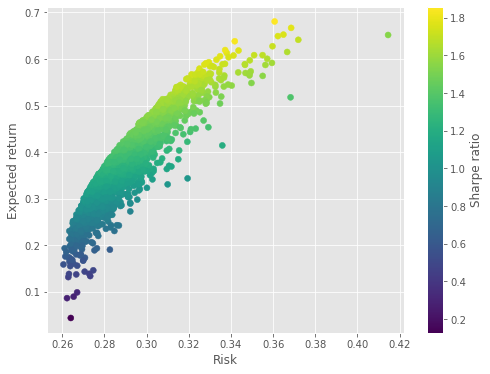

In [44]:
%matplotlib inline

# Assuming that risk free rate is 1%
rf = 0.01

plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
plt.scatter(p_volatility, p_returns, c=(p_returns - rf) / p_volatility, marker='o')
plt.xlabel('Risk')
plt.ylabel('Expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

## Optimisation

In [14]:
# Define a functon that return portfolio stats
def port_stats(weights, rf):
    ''' 
    Returning portfolio statistics

    Parameters:
    =================
    weights: array-like
        weights for different assets in portfolio (sum up to 1)
    rf: float
        risk-free rate
    
    Returns:
    =================
    p_returns: float
        expected returns of the portfolio
    p_volatility: float
        underlyings' risk
    (p_returns - risk-free) / p_volatility: float
        sharpe ratio
    '''
    weights = np.array(weights)
    p_returns = np.sum(df_rt.mean() * weights) * 252
    p_volatility = np.sqrt(np.dot(np.dot(weights.T, df_rt.cov() * 252), weights))
    sharpe = (p_returns - rf) / p_volatility
    
    return np.array([p_returns, p_volatility, sharpe])

In [15]:
import scipy.optimize as spo

In [16]:
# Maximise the Sharpe ratio 
# An equivalent to minimise the -Sharpe ratio

def max_sharpe(weights):
    return -port_stats(weights, rf)[2]

In [17]:
# Constraints of the optimisation
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Boundaries
bnds = tuple((0, 1) for x in range(len(assets)))

# Equal weights
len(assets) * [1. / len(assets),]

[0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666]

In [18]:
opt = spo.minimize(max_sharpe, len(assets) * [1. / len(assets),], method='SLSQP', constraints=cons, bounds=bnds)

In [19]:
opt

     fun: -1.9348147101635762
     jac: array([ 0.33508451, -0.02635783,  0.24200632,  0.18404777, -0.02621944,
        1.06743243])
 message: 'Optimization terminated successfully'
    nfev: 50
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.00000000e+00, 5.60402025e-01, 1.90962508e-17, 5.48361223e-18,
       4.39597975e-01, 0.00000000e+00])

In [20]:
print(opt['x'].round(3))
print(port_stats(opt['x'], rf))

[0.   0.56 0.   0.   0.44 0.  ]
[0.74575449 0.38027129 1.93481471]


In [21]:
# Minimising the portfolio variance
def min_variance(weights):
    return port_stats(weights, rf)[1] ** 2

In [22]:
optv = spo.minimize(min_variance, len(assets) * [1. / len(assets),], method='SLSQP', constraints=cons, bounds=bnds)

In [23]:
optv

     fun: 0.06688427738283967
     jac: array([0.13365549, 0.13962589, 0.13405372, 0.13335164, 0.13315778,
       0.13406933])
 message: 'Optimization terminated successfully'
    nfev: 85
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([0.24441633, 0.        , 0.07432698, 0.20662601, 0.05457249,
       0.42005819])

In [24]:
print(optv['x'].round(3))
print(port_stats(optv['x'], rf))

[0.244 0.    0.074 0.207 0.055 0.42 ]
[0.12599655 0.25861995 0.44852129]


## Efficient fontier

In [25]:
# Setting up a bunch of target return levels
target_returns = np.linspace(0.0, 0.7, 100)

# Define a function that can return the portfolio's volatility
def min_fun_vol(weights):
    return port_stats(weights, rf)[1]

In [26]:
target_vols = []

# Iterate all the target returns and find the minimum std
for target_return in target_returns:
    cons = ({'type': 'eq', 'fun': lambda x: port_stats(x, rf=rf)[0] - target_return}, 
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    res = spo.minimize(min_fun_vol, len(assets) * [1 / len(assets),], method='SLSQP', 
            bounds=bnds, constraints=cons)
    target_vols.append(res['fun'])

target_vols = np.array(target_vols)

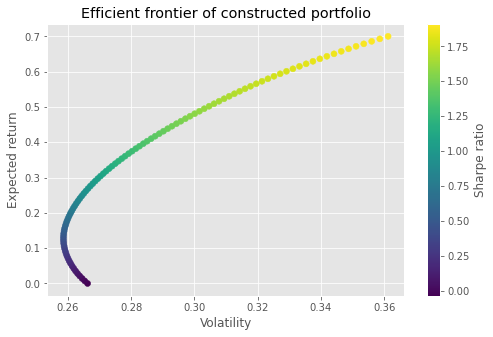

In [27]:
# Plotting the efficient frontier
plt.figure(figsize=(8,5))
plt.title('Efficient frontier of constructed portfolio')
plt.scatter(target_vols, target_returns, c=(target_returns-rf)/target_vols, marker='o')
plt.xlabel('Volatility')
plt.ylabel('Expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()